# Problem Set 3

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
%matplotlib inline

## Q1: Comparative Statics of the Basic McCall Model

For this question, we consider the plain-vanilla McCall Model that we covered in class:

- Time period is discrete, and the economic agents live forever.
- An unemployed agent receives in each period a job offer at wage $w$. The wage is a function of some underlying state $s$, i.e., $w(s)$.
- Assume there are $n$ states. $s$ is i.i.d. over time, with $q(s)$ being the probability mass function over the states.
- The unemployed agent observes the state $s$ at the beginning of each time period. She can choose whether to accept the wage offer or reject it.
    - If she accepts the offer, she will receive the same amount forever.
    - If she rejects the offer, she will receive an unemployment benefit $c$ in this period.
- The economic agents, either unemployed or employed, discount future earnings with a discount rate $\beta$.

As we discussed in previous classes, the value function of a currently unemployed agent, $v(s)$, is the solution to the following Bellman equation,

$$
V\left(s\right)=\max\left\{ \frac{w\left(s\right)}{1-\beta},c+\beta\sum_{s'\in\mathbb{S}}V\left(s'\right)q\left(s'\right)\right\}
$$

For the default parameter values and settings we use the same ones covered in the previous classes.

In [3]:
# Preparations and parameterization
n, a, b = 51, 200, 100                        # default parameters
q_default = stats.betabinom(n, a, b).pmf      # probability mass function

w_min, w_max = 10, 60
w_default = np.linspace(w_min, w_max, n)
q_grid = q_default(w_default)

c = 25       # Unemployment benefit
beta = 0.99  # Discount factor

### Q1.1 (A free lunch for you all) Solve the benchmark model

Solve $V(s)$ and plot it. (Note: you only need to plot the converged solution). Describe the optimal policy function in your own words: when will an unemployed agent choose to receive the offer, and when she will reject it?

The value function converges after  153 periods


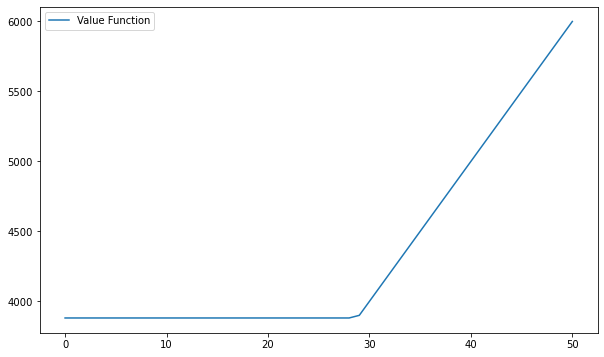

In [5]:
T = 200
v = np.zeros((T, n))
w = w_default / (1 - beta)

# initialization
# is_accept = (w > c)
# v[0, :] = w * (is_accept == True) + c * (is_accept == False)

for i in range(T - 1):
    # Continuation value?
    cont = c + beta * np.dot(v[i, :], q_grid)
    # Accept/reject given state?
    is_accept = (w > cont)
    v[i + 1, :] = w * (is_accept == True) + cont * (is_accept == False)
    
    diff = np.sum(np.abs(v[i + 1, :] - v[i, :]))
    if (diff < 1e-5):
        print("The value function converges after ", i, "periods")
        break

plt.figure(figsize = (10, 6))
plt.plot(v[i, :], label = "Value Function")
plt.legend(loc = 'best')
plt.show()

### Q1.2 Comparative Statics on the Reservation Wage

The indifference point that the economic agent choose to accept or to reject the offer is called the **reservation wage**.

Create a grid with 100 evenly spaced elements for beta that varies between 0.9 and 0.99. Solve the model holding all the other parameters the same, and plot the reservation wage as a function of beta (i.e., with beta on the horizontal axis and reservation wage on the vertical axis). What do you find? Can you explain it with economic intuition?

Now, hold beta and other parameters the same as before, but create a grid with 100 evenly spaced elements for c between 10.0 and 30.0. Then answer the same questions above: plot the reservation wage as a function of c, describe what you find, and try to explain the economic intuition behind.

In [10]:
def McCall_reservation_wage(beta, c):
    v = np.zeros(n)
    w = w_default / (1 - beta)
    
    while True:
        cont = c + beta * np.dot(v, q_grid)
        # Accept/reject given state?
        is_accept = (w > cont)
        v_next = w * (is_accept == True) + cont * (is_accept == False)

        diff = np.sum(np.abs(v_next - v))
        if (diff < 1e-5):
            break
        
        v = np.copy(v_next)
        
    res = (c + beta * np.dot(v, q_grid)) * (1 - beta)
    return res


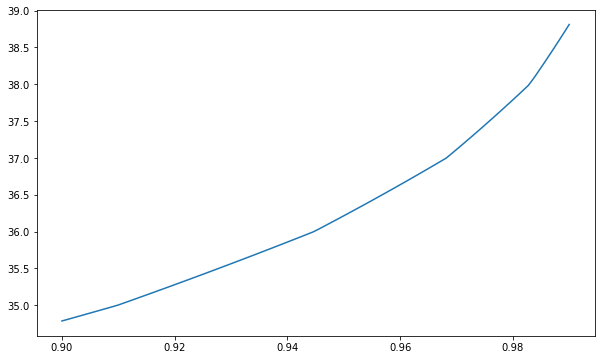

In [15]:
n_grid = 100
beta_grid = np.linspace(0.9, 0.99, n_grid)
res_beta = np.zeros(n_grid)
for i in range(n_grid):
    res_beta[i] = McCall_reservation_wage(beta_grid[i], c)

plt.figure(figsize = (10, 6))
plt.plot(beta_grid, res_beta)
plt.show()

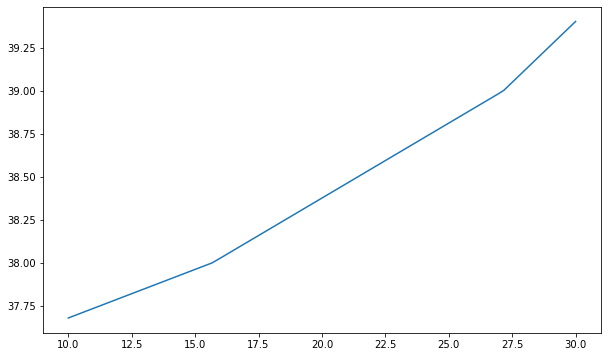

In [16]:
c_grid = np.linspace(10, 30, n_grid)
res_c = np.zeros(n_grid)
for i in range(n_grid):
    res_c[i] = McCall_reservation_wage(beta, c_grid[i])

plt.figure(figsize = (10, 6))
plt.plot(c_grid, res_c)
plt.show()

## Q2 McCall Model with Desperate Unemployed Job Seekers

*Try first thyself, and after call in God; For to the worker God himself lends aid.  -- Euripedes, "Hippolytus"*

Assume there are three types of agents in this economy: the Employed (E), the Unemployed (U), and the Desperate (D).

- Time period is discrete, and the economic agents live forever. The discount factor $\beta$ is common across all the agents.
- A Desperate (D) agent will receive an unemployment benefit $c$ every period. She might regain some courage to enter the job market: Type (D) will become the Unemployed (U) with a probability $\alpha$, and will remain Desperate (D) with probability $1-\alpha$.
- An Unemployed (U) agent receives in each period a job offer at wage $w(s)$ depend on the underlying state $s$. Assume there are $n$ states. $s$ is i.i.d. over time, with $q(s)$ being the probability mass function over the states:
    - This Unemployed (U) agent can choose to accept the offer she receives, or to reject the offer.
    - If she accepts the offer, she becomes Employed (E) and receive the same wage forever, starting from the current period.
    - If she rejects the offer, she will receive an unemployment benefit $c$ for the current period, and will become Desperate (D) next with a probability $\gamma$ or remain Unemployed (U) with a probability $1 - \gamma$.

### Q2.1 Bellman Equation

Write down the Bellman equation for the Desperate (D) and the Unemployed (U) agents. The value functions are denoted as $V^{D}$ and $V^{U}$ respectively.

$$
\begin{align*}
V^{D} & =c+\beta\left[\alpha\mathbb{E}V^{U}\left(s'\right)+\left(1-\alpha\right)V^{D}\right]\\
V^{U}\left(s\right) & =\max\left\{ \frac{w\left(s\right)}{1-\beta},c+\beta\mathbb{E}\left[\left(1-\gamma\right)V^{U}\left(s'\right)+\gamma V^{D}\right]\right\} 
\end{align*}
$$

### Q2.2 Solve the Model

We use the same parameterization as Q1, with additional assumptions: $\alpha = 0.1$ and $\gamma = 0.3$.

Solve the value functions $V^D$ and $V^U$. (hint: notice that the value of Desperate type is the same across all the states. However, the value of Unemployed type varies across the states.) Describe what you find, and try to explain the economic intuition behind.

In [17]:
# Preparations and parameterization
n, a, b = 51, 200, 100                        # default parameters
q_default = stats.betabinom(n, a, b).pmf      # probability mass function

w_min, w_max = 10, 60
w_default = np.linspace(w_min, w_max, n)
q_grid = q_default(w_default)

c = 25       # Unemployment benefit
beta = 0.99  # Discount factor
alpha = 0.1  # Transition probability from D to U
gamma = 0.3  # Transition probability from U to D

The value function converges after  61 periods


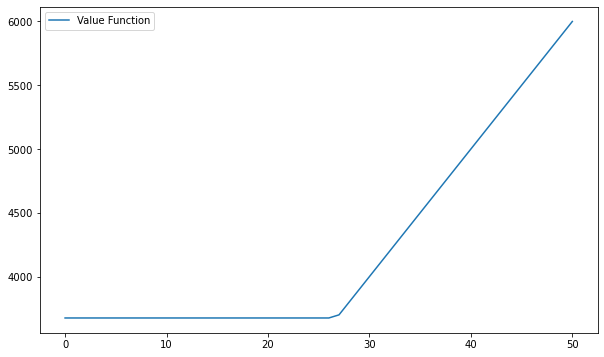

In [20]:
T = 200
v_u = np.zeros((T, n))
w = w_default / (1 - beta)

# initialization
# is_accept = (w > c)
# v[0, :] = w * (is_accept == True) + c * (is_accept == False)

for i in range(T - 1):
    # Desparate?
    v_d = (c + beta * (alpha * np.dot(v_u[i, :], q_grid))) / (1 - beta * (1 - alpha))
    # Continuation value?
    cont = c + beta * ((1 - gamma) * np.dot(v_u[i, :], q_grid) + gamma * v_d)
    # Accept/reject given state?
    is_accept = (w > cont)
    v_u[i + 1, :] = w * (is_accept == True) + cont * (is_accept == False)
    
    diff = np.sum(np.abs(v_u[i + 1, :] - v_u[i, :]))
    if (diff < 1e-5):
        print("The value function converges after ", i, "periods")
        break

plt.figure(figsize = (10, 6))
plt.plot(v_u[i, :], label = "Value Function")
plt.legend(loc = 'best')
plt.show()

### Q2.3 Comparative Statics

Now we set $\alpha = 0.5$, i.e., the Desperate type regains her confidence more easily. Solve the model. How do the solutions differ from Q2.2? How do the value function and the reservation wage change?

In [22]:
def McCall_extension(alpha):
    v_u = np.zeros(n)
    w = w_default / (1 - beta)
    
    while True:
        v_d = (c + beta * (alpha * np.dot(v_u, q_grid))) / (1 - beta * (1 - alpha))
        # Continuation value?
        cont = c + beta * ((1 - gamma) * np.dot(v_u, q_grid) + gamma * v_d)
        # Accept/reject given state?
        is_accept = (w > cont)
        v_u_next = w * (is_accept == True) + cont * (is_accept == False)

        diff = np.sum(np.abs(v_u_next - v_u))
        if (diff < 1e-5):
            break
        
        v_u = np.copy(v_u_next)
        
    return v_u

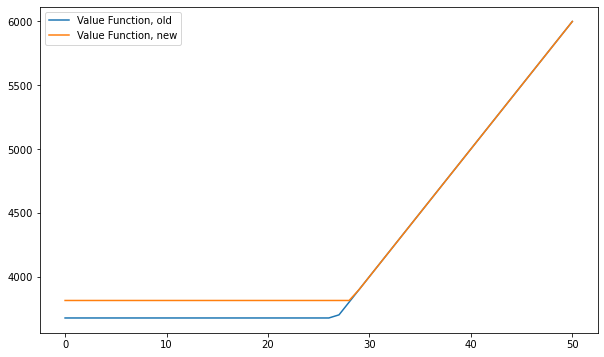

In [23]:
v_u_old = McCall_extension(0.1)
v_u_new = McCall_extension(0.5)

plt.figure(figsize = (10, 6))
plt.plot(v_u_old, label = "Value Function, old")
plt.plot(v_u_new, label = "Value Function, new")
plt.legend(loc = 'best')
plt.show()

### Q2.4 (Bonus, 5 pts) Canada Emergency Response Benefit

Due to COVID-19, a lot of firms/establishments freeze their hiring quota, hence making the unemployed guys easier to become more desperate. The Canadian government then (equivalently) increases the unemployment benefit (i.e., CERB) during this period. However, that means Canada faces a higher deficit in the future, and the Canadian government have to increase the taxes somehow to finance it.

Suppose now $\alpha = 0.1, \gamma = 0.6, c = 30$. And there's a income tax rate $\tau = 0.3$ on the wages. That is to say the employed workers can only receive $(1-\tau)*w$ forever for some job offer with wage $w$.

1. Solve the value function
2. How does the reservation wage change? What does that imply?
3. Why CERB might/might not be a good policy?